In [2]:
import os
import sys
import matplotlib.pyplot as plt
import torch
from torch.utils.data import  DataLoader
import torchvision.utils as vutils
import torch.optim as optim
import torch.autograd as autograd
from ImageAestheticsGANs.AADB.AADB import AADB_binaries, AADB
from ImageAestheticsGANs.TheSUN.SUN import SUN
from ImageAestheticsGANs.models.ACGAN import Generator, Discriminator
# from models.cGAN import Generator, Discriminator
from ImageAestheticsGANs.utils.utils import *
from ImageAestheticsGANs.models.ResNet18 import RegressionNetwork
import torch.nn as nn

import torchvision.transforms as T
from PIL import Image

In [9]:
batch_size = 128
max_epochs = 1600
latent_dim = 128
n_channels = 3
image_size = 128
ngf = 128   # feature map gen
ndf = 128   # feature map disc
beta = 0.5  # Adam
lrg = 0.0005  # Learning rate for optimizers
lrd = 0.0001
is_load = False
ckpt_path = 'F:\Projects\Disertatie\RESULTS\Final\checkpoint_iteration_123275.tar'  # to set if checkpoint
n_critic = 5
lam_gp = 10

In [4]:
data_path = 'F:\Projects\Disertatie\ImageAestheticsGANs\AADB\\'
aadb = AADB_binaries(data_path, 128)
aadb_test = AADB_binaries(data_path, 128, test=True)
n_classes = aadb.get_num_classes()
n_classes

5

In [5]:
aadb = aadb + aadb_test
train_dl = DataLoader(aadb, batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [7]:
net_G = Generator(ngf, n_classes, image_size, n_channels, latent_dim).to(device)
net_D = Discriminator(ndf, n_channels, image_size, n_classes).to(device)

In [8]:
testing_model = RegressionNetwork(backbone='resnet18', num_attributes=n_classes, pretrained=True)
testing_model = testing_model.to('cuda')
testing_model.load_state_dict(torch.load("F:\Projects\Disertatie\RESULTS\Final_resnet\AADB_epoch_190_accuracy_0.6408_.pt")['model'])
testing_model.eval()

F:\Projects\Disertatie\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
F:\Projects\Disertatie\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RegressionNetwork(
  (model): Sequential(
    (0): Backbone(
      (model): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [11]:
checkpoint = torch.load(ckpt_path)
gen = Generator(ngf, n_classes, image_size, n_channels, latent_dim).to('cuda')
gen.load_state_dict(checkpoint['netG_state_dict'])
gen.eval()

Generator(
  (exp): Linear(in_features=5, out_features=28, bias=True)
  (main): Sequential(
    (0): Linear(in_features=156, out_features=65536, bias=True)
    (1): Reshape()
    (2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)

In [259]:
sample_noise = torch.randn(1, latent_dim, device=device)
test_labels = torch.tensor([0, 0, 0, 0, 0], dtype=torch.float32, device=device)

In [260]:
sample = gen(sample_noise, test_labels.view(1,n_classes)).squeeze().cpu().detach()
vutils.save_image(sample, os.path.join("F:\Projects\Disertatie", 'test.jpg'), normalize=True)

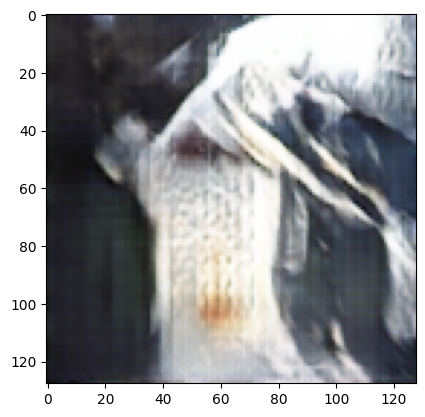

In [261]:
plt.imshow(to_pil(sample))

In [262]:
sample_tensor = sample.to("cuda").unsqueeze(0)
y_pred = testing_model(sample_tensor)
predicted = y_pred > 0.5
predicted = predicted.cpu().detach().numpy()
y = test_labels.cpu().numpy()

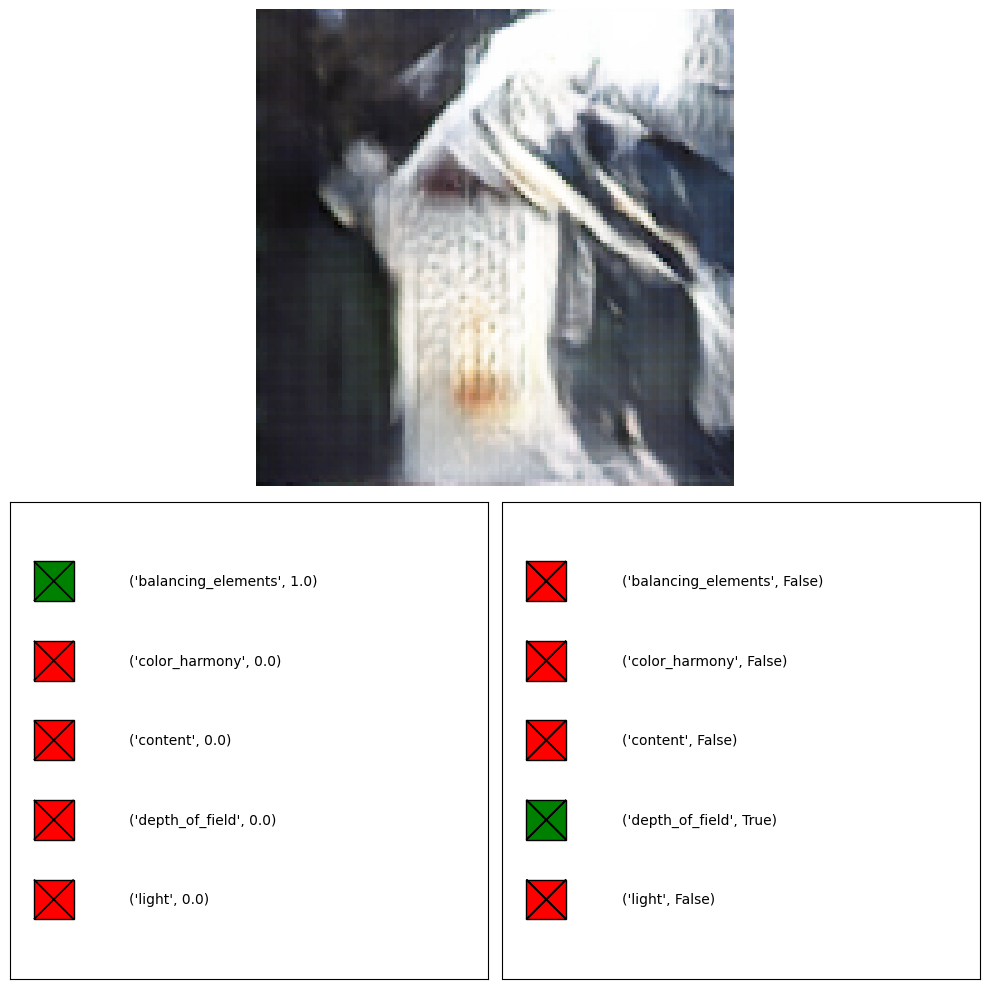

In [263]:
display_aesthetics(sample, y, predicted, interval=[0, 0], score=False)